![https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png](https://raw.githubusercontent.com/inverted-ai/invertedai/master/docs/images/banner-small.png)

In [ ]:
!pip install invertedai
import os
from IPython.display import clear_output
clear_output()
os.kill(os.getpid(), 9)

In [1]:
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
import invertedai as iai
import time
clear_output()

# Provide your API key

In [2]:
iai.add_apikey("")

# Setup

Set up the simulation by defining the location, simulation length (1 step = 0.1 second), and some other constants.

In [3]:
location = "iai:drake_street_and_pacific_blvd"
#location = "iai:marine_drive_viewpoint_3"

SIMULATION_LENGTH = 30
RENDERING_FOV = 130
FIGURE_SIZE = 10
AGENT_COUNT = 10
GIF_RATIO = 1.0
GIF_SIZE = 100*FIGURE_SIZE

# Preview the map location

(None, <matplotlib.image.AxesImage at 0x7f10424cb5e0>)

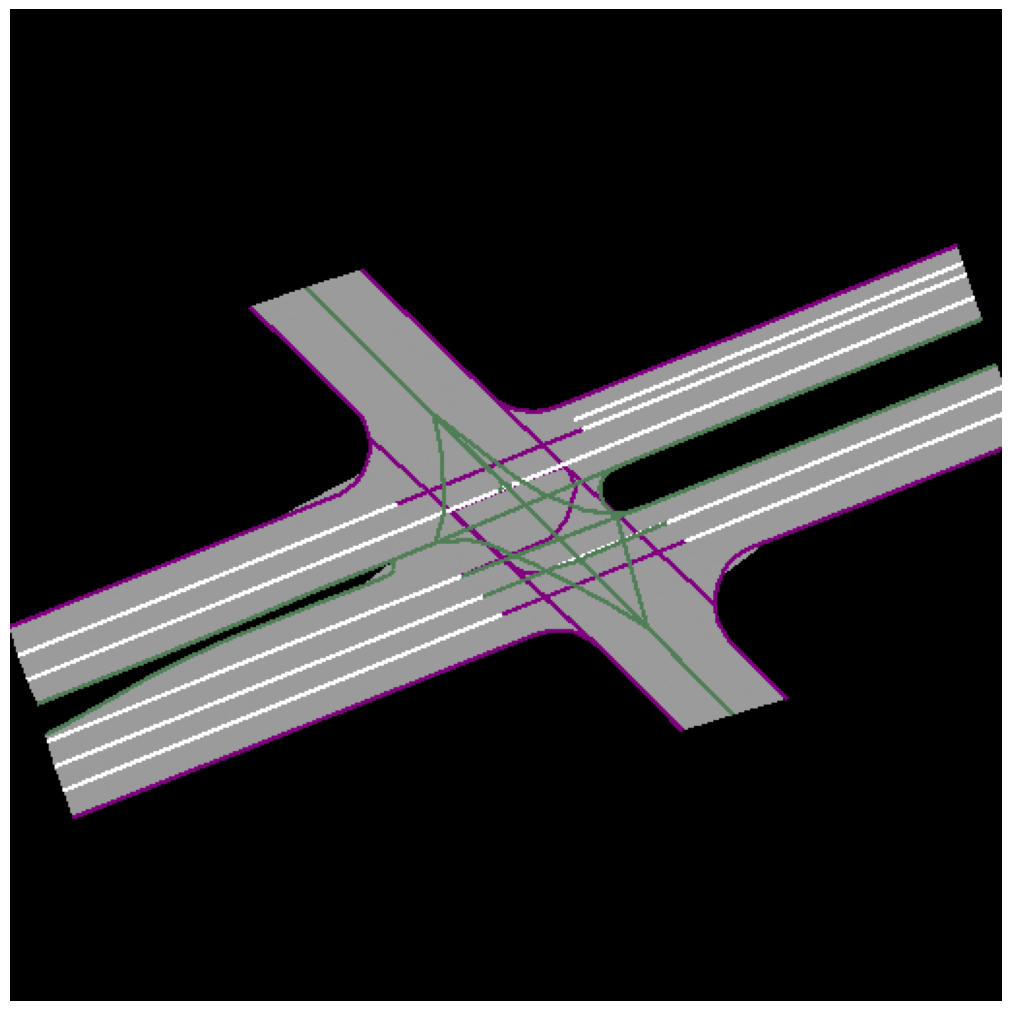

In [4]:
location_info_response = iai.location_info(location=location,rendering_fov=RENDERING_FOV)
rendered_map = location_info_response.birdview_image.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

# Light
First check if there are any traffic-lights on the map and then get the states

In [5]:
if any(actor.agent_type == "traffic-light" for actor in location_info_response.static_actors):
    scene_has_lights = True
    light_response = iai.light(location=location)
else:
    light_response = None
    scene_has_lights = False

# Initialize
Initialize the simulation by spawning NPCs on the map


(None, <matplotlib.image.AxesImage at 0x7f10417cb070>)

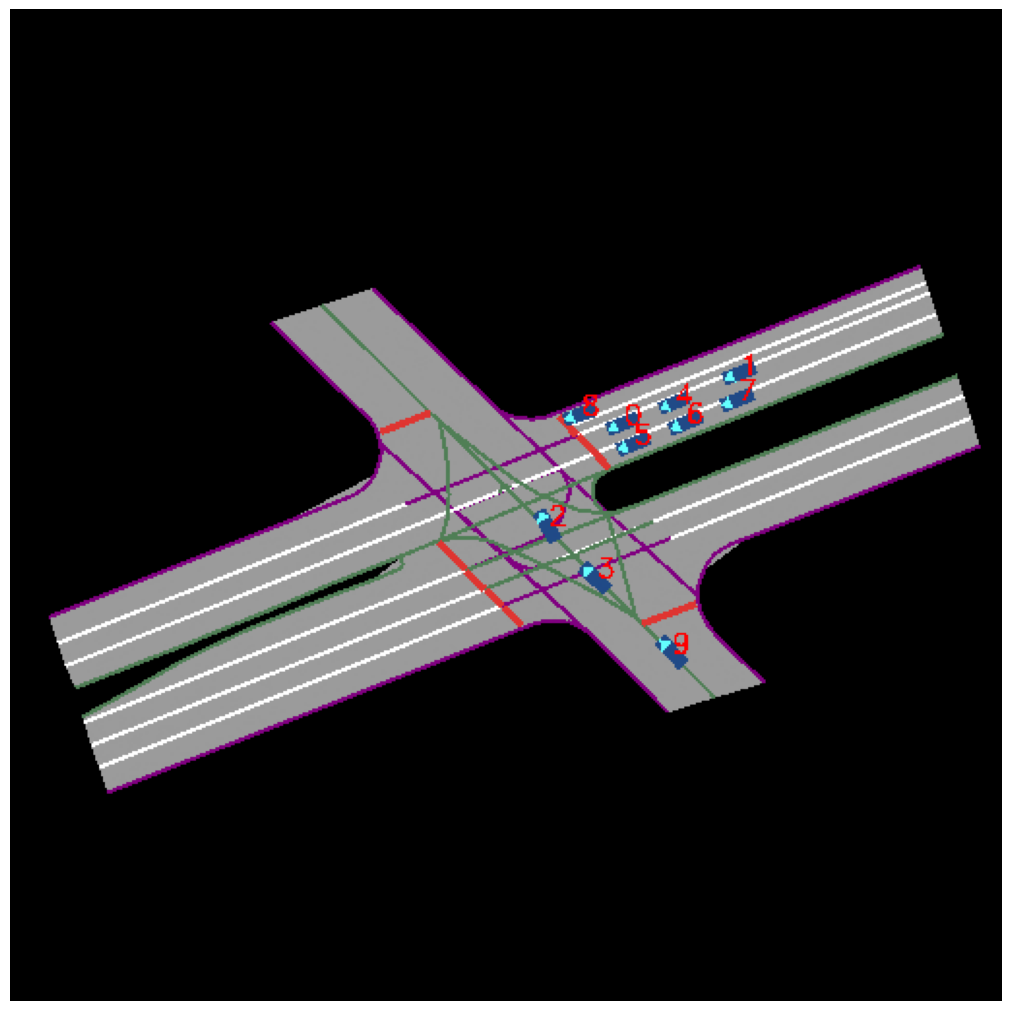

In [6]:
response = iai.initialize(location,
    traffic_light_state_history=[light_response.traffic_lights_states] if scene_has_lights else None,
    get_birdview = True,
    agent_count = AGENT_COUNT,)
agent_attributes = response.agent_attributes
rendered_map = response.birdview.decode()
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off(), ax.imshow(rendered_map)

# Drive
Start the simulation.\
(Returning the birdviews will casue a much longer response time than running without them.)

Time to run simulation: 123.26s


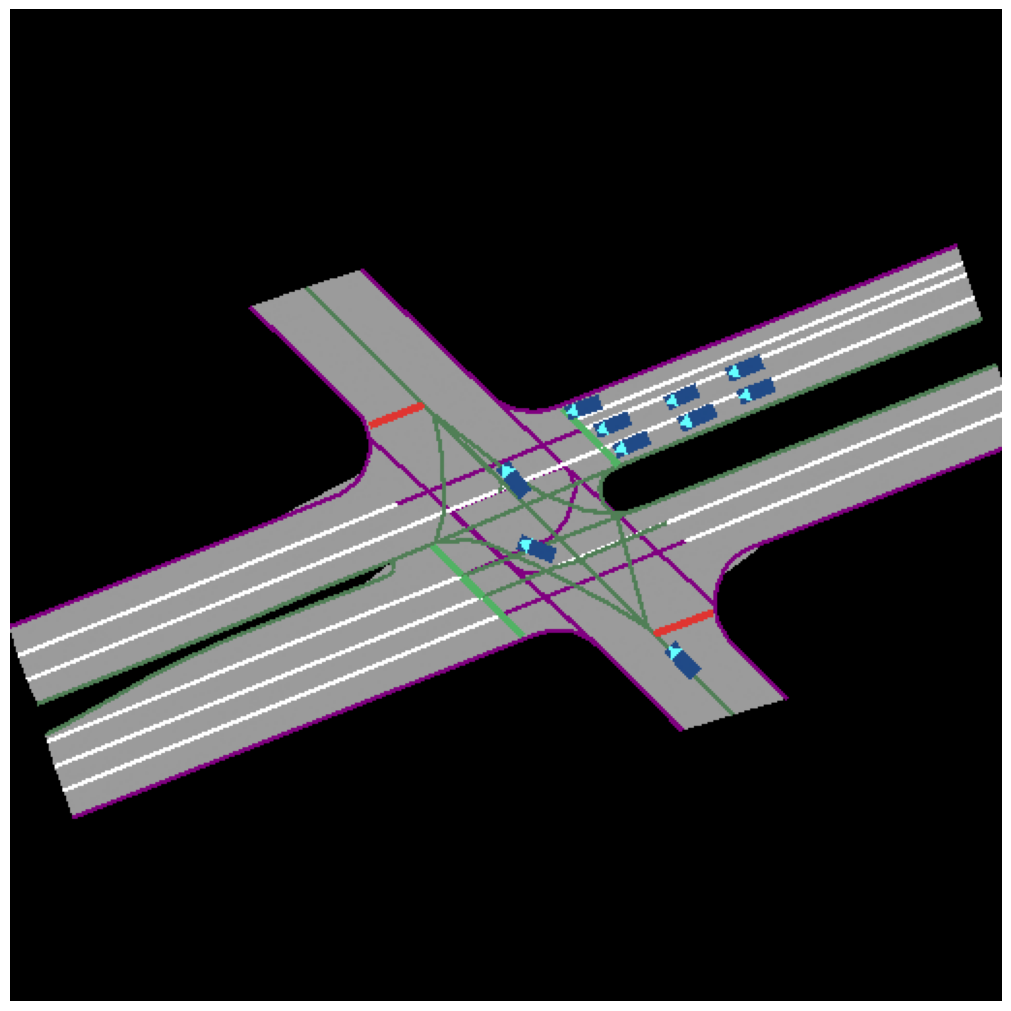

In [7]:
gif_name = 'iai-drive.gif'
fig, ax = plt.subplots(constrained_layout=True, figsize=(FIGURE_SIZE, FIGURE_SIZE))
ax.set_axis_off()
frames = []
is_get_birdview = True
t0 = time.time()
for t in range(SIMULATION_LENGTH):
    light_response = iai.light(location=location, recurrent_states=light_response.recurrent_states) if scene_has_lights else None

    response = iai.drive(
        agent_attributes=agent_attributes,
        agent_states=response.agent_states,
        recurrent_states=response.recurrent_states,
        get_birdview=is_get_birdview,
        location=location,
        rendering_fov=RENDERING_FOV,
        get_infractions=True,
        traffic_lights_states=light_response.traffic_lights_states if scene_has_lights else None,
    )

    if is_get_birdview:
        image = response.birdview.decode()
        frames.append(image)
        ax.imshow(frames[-1])
        display(plt.gcf())


    print(f"Processing frame number {t+1} of {SIMULATION_LENGTH}.")
    clear_output(wait=True)
t1 = time.time()
print(f'Time to run simulation: {t1 - t0:.2f}s')
if is_get_birdview: imageio.mimsave(gif_name, np.array(frames), format="GIF-PIL")

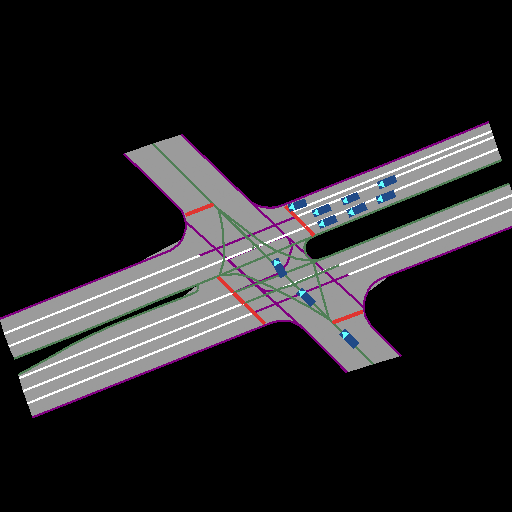

In [8]:
Image(gif_name, width = GIF_SIZE*GIF_RATIO, height = GIF_SIZE)